# Data Simulation

This notebook utilizes data simulation techniques to generate synthetic data. Prior to data simulation, we begin by implementing several utility functions that are essential for the process.

In [1]:
import pandas as pd
import numpy as np
import datetime
from scipy.interpolate import interp1d
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import shutil
import os
import sys
import datetime
import copy
from pandas.tseries.offsets import BDay, DateOffset

### Utility Functions for Data Simulation
We will first implement some utility functions and then proceed to generate the train, validation, and test data.

The `time_to_maturity` function takes lists of start dates and end dates as input and returns the time to maturity in years. It assumes a 253-day trading year and considers the business days between the start dates and maturity dates. The output is a numeric value representing the time to maturity as a fraction of a year.

By using this function, one can determine the time remaining until maturity for various financial instruments or contracts. This information is crucial for performing financial calculations and conducting analyses that depend on the remaining time until maturity.

Code explanation:

- `trading_days_per_year = 253`: This variable represents the number of trading days in a year, assuming a 253-day trading year.

- `maturity_dates = pd.DatetimeIndex(end_dates)`: The `end_dates` list is converted to a Pandas `DatetimeIndex`, allowing for convenient date operations.

- `time_to_maturity = np.busday_count(start_dates.values.astype('datetime64[D]'), maturity_dates.values.astype('datetime64[D]'))`: The `np.busday_count` function calculates the number of business days between the start dates and the maturity dates. It takes into account weekends and specified holidays.

- `return time_to_maturity / trading_days_per_year`: The calculated time to maturity is divided by the trading days per year to obtain the time to maturity in years as a fraction.


In [2]:
def time_to_maturity(start_dates, end_dates):
    trading_days_per_year = 253
    maturity_dates = pd.DatetimeIndex(end_dates)
    time_to_maturity = np.busday_count(start_dates.values.astype('datetime64[D]'),
                                      maturity_dates.values.astype('datetime64[D]'))
    return time_to_maturity / trading_days_per_year

The `claculate_interest_rate` function calculates the interest rate to the specified expiry by interpolation. This function can be used to interpolate interest rates based on a given set of days and corresponding rates. Interpolation is a useful technique in financial analysis and modeling, allowing for the estimation of rates at specific points in time.

Code explanation:

- `group` represents the input data group containing 'days' and 'rate' values.

- `num_days` is the number of days to which the interest rate needs to be interpolated.

- The function checks if the data group contains more than one point by using `len(ds) > 1`. If it does, it proceeds with interpolation.

- Inside the `if` condition, the `interp1d` function is used for interpolation. It takes the 'days' and 'rate' values from the data group as inputs and performs the interpolation. The `bounds_error=False` argument allows extrapolation when the number of days is outside the available range, and `fill_value=np.nan` sets the rate to NaN for extrapolated values.

- The interpolated rate for the given number of days is stored in a DataFrame named `var`, which has 'days' and 'rate' as columns. The interpolated rate is calculated using `func(num_days)`.

- If the data group has only one point (indicating insufficient data for interpolation), the `else` condition is executed. In this case, the rate is set to NaN in the `var` DataFrame.

- Finally, the function returns the `var` DataFrame with the interpolated rate for the specified number of days.

In [3]:
def claculate_interest_rate(data_group, num_days):
    """
    This function interpolates the interest rate to the specified expiry by interpolation.
    It takes a data group containing 'days' and 'rate' values and interpolates the rate for
    the given number of days.
    If the data group contains multiple points, interpolation is performed using the
    interp1d function.
    If the data group has only one point, the rate is set to NaN.
    The function returns a DataFrame with the interpolated rate for the given number of days.
    """

    days = data_group['days'].values
    rates = data_group['rate'].values

    if len(days) > 1:
        # Perform interpolation using the interp1d function
        interpolator = interp1d(days, rates, bounds_error=False, fill_value=np.nan)
        interpolated_rate = pd.DataFrame({'days': num_days, 'rate': interpolator(num_days)})
        return interpolated_rate
    else:
        # Only one point in the data group, set the rate to NaN
        interpolated_rate = pd.DataFrame({'days': num_days, 'rate': np.nan})
        return interpolated_rate


The `incorporate_tomorrow_info` function is used to incorporate relevant tomorrow's information into a given dataframe. This function is useful when it is needed to include future data points in a dataframe, such as tomorrow's stock prices, volumes, or other relevant information. By adjusting the 'date' column and renaming the columns, the function seamlessly incorporates the required information into the existing dataframe for further analysis or processing.

Code explanation: 

- The function takes the following parameters:
  - `data_frame`: The dataframe to which tomorrow's information will be added.
  - `offset_business_days`: The time gap between the current price and the next price, expressed in business days.
  - `offset_key`: A key used to identify the offset in the column names.
  - `future_trading_volume`: The future trading volume to be joined.

- The code defines a list called `columns_to_copy` to store the column names of interest, including 'date', 'optionid', 'S0', 'V0', and 'implvol0'. If the dataframe contains a column named 'Var0', it is also added to the list.

- If `future_trading_volume` is provided, the 'volume' column is appended to the `columns_to_copy` list.

- A temporary dataframe, `temp_df`, is created by copying the columns specified in `columns_to_copy` from the original dataframe.

- The 'date' column in `temp_df` is adjusted by subtracting the specified `offset_business_days`.

- The column names in `temp_df` are renamed based on the `new_columns` dictionary, which maps the original column names to their modified counterparts with the `offset_key` appended.

- Finally, the `temp_df` dataframe is joined with the original dataframe, `data_frame`, using the 'date' and 'optionid' columns as the join keys.

- The modified `data_frame` with tomorrow's information added is returned.

In [4]:
def incorporate_tomorrow_info(data_frame,offset_business_days,offset_key='_1D',future_trading_volume=None):
    columns_to_copy = ['date', 'optionid', 'S0', 'V0', 'implvol0']
    new_columns = {
        'S0': f'S{offset_key}', 
        'V0': f'V{offset_key}', 
        'implvol0': f'implvol{offset_key}'}
    if 'Var0' in data_frame.columns:
        columns_to_copy.append('Var0')
        new_columns['Var0'] = f'Var{offset_key}'

    if future_trading_volume:
        columns_to_copy.append('volume')
        new_columns['volume'] = f'volume{offset_key}'
        
    temp_df = data_frame[columns_to_copy].copy()
    temp_df['date'] -= offset_business_days
    temp_df.rename(columns=new_columns, inplace=True) 
    data_frame = data_frame.join(temp_df.set_index(['date', 'optionid']), on=['date', 'optionid'])
    return data_frame

The `bs_formula_call` function allows you to determine the theoretical price of a European call option based on the Black-Scholes formula. It takes into account parameters such as volatility, stock price, strike price, time to maturity, and interest rate, which are essential in option pricing and financial analysis.

Code explanation: 

- The function takes the following parameters:
  - `volatility`: The volatility of the underlying asset.
  - `stock_price`: The current price of the underlying asset.
  - `strike_price`: The strike price of the option.
  - `time_to_maturity`: The time to maturity of the option in years.
  - `interest_rate`: The risk-free interest rate.

- Inside the function, the first step is to calculate the two components, `d1` and `d2`, of the Black-Scholes formula.

- `d1` is calculated using the formula: (ln(S/K) + (r + σ^2/2) * τ) / (σ * sqrt(τ))
  - `S`: The current price of the underlying asset (stock_price).
  - `K`: The strike price of the option.
  - `r`: The risk-free interest rate (interest_rate).
  - `σ`: The volatility of the underlying asset (volatility).
  - `τ`: The time to maturity of the option in years (time_to_maturity).

- `d2` is calculated by subtracting the square root of (σ^2 * τ) from `d1`.

- Finally, the call option price (`call_option_price`) is computed using the Black-Scholes formula:
  - The first term represents the present value of the expected stock price at expiration, discounted at the risk-free interest rate.
  - The second term represents the present value of the strike price, also discounted at the risk-free interest rate.

- The computed call option price is returned by the function.



In [5]:
def bs_formula_call(volatility, stock_price, strike_price,
                                   time_to_maturity, interest_rate):
    # calculate_bs_call_option_price
    d1 = ((np.log(stock_price / strike_price) + (interest_rate + volatility ** 2 / 2) * time_to_maturity)
            / (np.sqrt(volatility ** 2 * time_to_maturity)))
    d2 = d1 - np.sqrt(volatility**2 * time_to_maturity)
    call_option_price = stock_price * norm.cdf(d1) - strike_price * np.exp(-interest_rate * time_to_maturity) * norm.cdf(d2) 
    return call_option_price

The `bs_formula_put` function allows us to determine the theoretical price of a European put option based on the Black-Scholes formula. It takes into account parameters such as volatility, stock price, strike price, time to maturity, and interest rate, which are essential in option pricing and financial analysis.

Code explanation: 

- The function takes the following parameters:
  - `volatility`: The volatility of the underlying asset.
  - `stock_price`: The current price of the underlying asset.
  - `strike_price`: The strike price of the option.
  - `time_to_maturity`: The time to maturity of the option in years.
  - `interest_rate`: The risk-free interest rate.

- Inside the function, the first step is to calculate the two components, `d1` and `d2`, of the Black-Scholes formula.

- `d1` is calculated using the formula: (ln(S/K) + (r + σ^2/2) * τ) / (σ * sqrt(τ))
  - `S`: The current price of the underlying asset (stock_price).
  - `K`: The strike price of the option.
  - `r`: The risk-free interest rate (interest_rate).
  - `σ`: The volatility of the underlying asset (volatility).
  - `τ`: The time to maturity of the option in years (time_to_maturity).

- `d2` is calculated by subtracting the square root of (σ^2 * τ) from `d1`.

- Finally, the put option price (`put_option_price`) is computed using the Black-Scholes formula:
  - The first term represents the present value of the expected strike price at expiration, discounted at the risk-free interest rate.
  - The second term represents the present value of the stock price, also discounted at the risk-free interest rate.

- The computed put option price is returned by the function.



In [6]:
def bs_formula_put(volatility, stock_price, strike_price, time_to_maturity, interest_rate):
    d1 = ((np.log(stock_price / strike_price) + (interest_rate + volatility ** 2 / 2) * time_to_maturity)
            / (np.sqrt(volatility ** 2 * time_to_maturity)))
    d2 = d1 - np.sqrt(volatility**2 * time_to_maturity)
    put_option_price = norm.cdf(-d2) * strike_price * np.exp(-interest_rate * time_to_maturity) - norm.cdf(-d1) * stock_price
    return put_option_price

The `bs_call_price` function allows us to determine the theoretical price of a European call option based on the Black-Scholes formula. It handles cases where the time to maturity is close to zero separately to avoid numerical issues. The function takes into account parameters such as volatility, stock price, strike price, time to maturity, and interest rate, which are essential in option pricing and financial analysis.

Code explanation:

- The function takes the following parameters:
  - `volatility`: The volatility of the underlying asset.
  - `stock_price`: The current price of the underlying asset.
  - `strike_price`: The strike price of the option.
  - `time_to_maturity`: The time to maturity of the option in years.
  - `interest_rate`: The risk-free interest rate.

- Inside the function, the first step is to identify the cases where the time to maturity is close to zero using the condition `time_to_maturity < 1e-6`. This is done to avoid numerical issues.

- The function initializes an array `call_option_prices` with the same shape as the `stock_price` array to store the calculated call option prices.

- For the cases where the time to maturity is close to zero (`is_time_to_maturity_close_to_zero` is True), the call option prices are calculated as the maximum of zero and the difference between the stock price and the strike price.

- For the cases where the time to maturity is not close to zero (`~is_time_to_maturity_close_to_zero`), the call option prices are calculated using the `bs_call_option_formula` function, which represents the Black-Scholes formula. This calculation considers the volatility, stock price, strike price, time to maturity, and interest rate.

- The calculated call option prices are stored in the `call_option_prices` array.

- Finally, the array containing the call option prices is returned by the function.

In [7]:
def bs_call_price(volatility, stock_price, strike_price, time_to_maturity, interest_rate):
    is_time_to_maturity_close_to_zero = (time_to_maturity < 1e-6)
    call_option_prices = np.zeros_like(stock_price)
    
    # Calculate call option prices for time to maturity close to zero
    call_option_prices[is_time_to_maturity_close_to_zero] = np.maximum(0, (stock_price - strike_price))[is_time_to_maturity_close_to_zero]

    # Calculate call option prices using the Black-Scholes formula for other cases
    call_option_prices[~is_time_to_maturity_close_to_zero] = bs_formula_call(
        volatility[~is_time_to_maturity_close_to_zero],
        stock_price[~is_time_to_maturity_close_to_zero],
        strike_price[~is_time_to_maturity_close_to_zero],
        time_to_maturity[~is_time_to_maturity_close_to_zero],
        interest_rate[~is_time_to_maturity_close_to_zero])
    return call_option_prices

The `cal_d1` function allows us to compute the d1 term, which is a crucial component in option pricing formulas such as the Black-Scholes formula. It takes into account parameters such as volatility, stock price, strike price, time to maturity, and interest rate. The function handles cases where the time to maturity is close to zero separately to avoid division by zero. The output is an array of d1 values corresponding to the input parameters.

Code explanation:

- The function takes the following parameters:
  - `volatility`: The volatility of the underlying asset.
  - `stock_price`: The current price of the underlying asset.
  - `strike_price`: The strike price of the option.
  - `time_to_maturity`: The time to maturity of the option in years.
  - `interest_rate`: The risk-free interest rate.

- Inside the function, the first step is to identify the cases where the time to maturity is close to zero using the condition `time_to_maturity < 1e-6`. This is done to avoid division by zero.

- The function initializes an array `d1` with the same shape as the `stock_price` array to store the calculated values of d1.

- For the cases where the time to maturity is not close to zero (`~is_time_to_maturity_close_to_zero`), the d1 values are calculated using the corresponding formulas. This involves taking the logarithm of the ratio between the stock price and the strike price, adding the product of the interest rate and half the square of the volatility, and dividing the result by the square root of the product of the volatility squared and the time to maturity.

- For the cases where the time to maturity is close to zero (`is_time_to_maturity_close_to_zero`), the d1 values are calculated similarly, but a small positive value (`1e-10`) is added to the time to maturity to avoid division by zero.

- The calculated d1 values are stored in the `d1` array.

- Finally, the array containing the d1 values is returned by the function.

In [8]:
def calculate_d1(volatility, stock_price, strike_price, time_to_maturity, interest_rate):
    is_time_to_maturity_close_to_zero = (time_to_maturity < 1e-6)
    d1 = np.zeros_like(stock_price)

    # Calculate d1 for time to maturity not close to zero
    d1[~is_time_to_maturity_close_to_zero] = (np.log(stock_price[~is_time_to_maturity_close_to_zero] / strike_price[~is_time_to_maturity_close_to_zero]) + (interest_rate[~is_time_to_maturity_close_to_zero] + volatility[~is_time_to_maturity_close_to_zero] ** 2 / 2) * time_to_maturity[~is_time_to_maturity_close_to_zero]) / np.sqrt(volatility[~is_time_to_maturity_close_to_zero] ** 2 * time_to_maturity[~is_time_to_maturity_close_to_zero])
    
    # Calculate d1 for time to maturity close to zero
    d1[is_time_to_maturity_close_to_zero] = (np.log(stock_price[is_time_to_maturity_close_to_zero] / strike_price[is_time_to_maturity_close_to_zero]) + (interest_rate[is_time_to_maturity_close_to_zero] + volatility[is_time_to_maturity_close_to_zero] ** 2 / 2) * time_to_maturity[is_time_to_maturity_close_to_zero]) / np.sqrt(volatility[is_time_to_maturity_close_to_zero] ** 2 * (time_to_maturity[is_time_to_maturity_close_to_zero] + 1e-10))
    return d1


The `calculate_call_delta` function calculates the delta of a call option using the Black-Scholes formula.

Code explanation:

- `d1 = calculate_d1(volatility, stock_price, strike_price, time_to_maturity, interest_rate)`: The function `calculate_d1` is called to calculate the value of d1 in the Black-Scholes formula. This function takes the inputs of volatility, stock price, strike price, time to maturity, and interest rate, and returns the value of d1.

- `delta = norm.cdf(d1)`: The `norm.cdf` function calculates the cumulative distribution function of a standard normal distribution, which represents the delta of the call option. The calculated value of d1 is passed to this function to obtain the delta value.

- `return delta`: The calculated delta value is returned as the output of the function.


In [9]:
def calculate_call_delta(volatility, stock_price, strike_price, time_to_maturity, interest_rate):
    # calculate_call_delta
    d1 = calculate_d1(volatility, stock_price, strike_price, time_to_maturity, interest_rate)
    delta = norm.cdf(d1)
    return delta

The `calculate_put_delta` function calculates the delta of a put option using the Black-Scholes formula.

Code explanation:

- `call_delta = calculate_call_delta(volatility, stock_price, strike_price, time_to_maturity, interest_rate)`: The function `calculate_call_delta` is called to calculate the delta of a call option using the Black-Scholes formula. This function takes the inputs of volatility, stock price, strike price, time to maturity, and interest rate, and returns the delta value of the call option.

- `put_delta = call_delta - 1`: The calculated delta of the call option is subtracted by 1 to obtain the delta value of the put option. This is based on the relationship between call and put options, where the put delta is equal to the call delta minus 1.

- `return put_delta`: The calculated put delta value is returned as the output of the function.

In [10]:
def calculate_put_delta(volatility, stock_price, strike_price, time_to_maturity, interest_rate):
    call_delta = calculate_call_delta(volatility, stock_price, strike_price, time_to_maturity, interest_rate)
    put_delta = call_delta - 1
    return put_delta

The ` calculate_call_theta` function calculates the theta of a call option using the Black-Scholes formula.

Code explanation:

- `d1 = calculate_d1(volatility, stock_price, strike_price, time_to_maturity, interest_rate)`: The function `calculate_d1` is called to calculate the d1 parameter used in the Black-Scholes formula. This function takes the inputs of volatility, stock price, strike price, time to maturity, and interest rate, and returns the d1 value.

- `d2 = d1 - volatility * np.sqrt(time_to_maturity)`: The d2 parameter is calculated by subtracting the product of volatility and the square root of time to maturity from the d1 value.

- `theta = - stock_price * norm.pdf(d1) * volatility / (2 * np.sqrt(time_to_maturity + 1e-10)) - interest_rate * strike_price * np.exp(-interest_rate * time_to_maturity) * norm.cdf(d2)`: The theta value is calculated using the Black-Scholes formula, which involves various components such as the stock price, normal probability density function, volatility, time to maturity, interest rate, strike price, and cumulative distribution function. The formula represents the rate of change in the option price with respect to time.

- `return theta`: The calculated theta value is returned as the output of the function.

In [11]:
def calculate_call_theta(volatility, stock_price, strike_price, time_to_maturity, interest_rate):
    # calculate_call_theta
    d1 = calculate_d1(volatility, stock_price, strike_price, time_to_maturity, interest_rate)
    d2 = d1 - volatility * np.sqrt(time_to_maturity)
    theta = - stock_price * norm.pdf(d1) * volatility / (2 * np.sqrt(time_to_maturity + 1e-10)) - interest_rate * strike_price * np.exp(-interest_rate * time_to_maturity) * norm.cdf(d2)
    return theta

The `calculate_gamma` function calculates the gamma of an option using the Black-Scholes formula.

Code explanation:

- `d1 = calculate_d1(volatility, stock_price, strike_price, time_to_maturity, interest_rate)`: The function `calculate_d1` is called to calculate the d1 parameter used in the Black-Scholes formula. This function takes the inputs of volatility, stock price, strike price, time to maturity, and interest rate, and returns the d1 value.

- `ix_int = (time_to_maturity < 1e-6)`: An index array is created to identify options with a time to maturity less than a small threshold value.

- `gamma = np.zeros(len(stock_price))`: An array of zeros is initialized to store the calculated gamma values.

- `gamma[ix_int] = norm.pdf(d1[ix_int]) / (stock_price[ix_int] * np.sqrt(time_to_maturity[ix_int] + 1e-10) * volatility[ix_int])`: For options with time to maturity less than the threshold, the gamma is calculated using the Black-Scholes formula, which involves the normal probability density function, stock price, square root of time to maturity (with a small adjustment to avoid division by zero), and volatility.

- `gamma[~ix_int] = norm.pdf(d1[~ix_int]) / (stock_price[~ix_int] * np.sqrt(time_to_maturity[~ix_int]) * volatility[~ix_int])`: For options with time to maturity greater than the threshold, the gamma is calculated using the Black-Scholes formula without the adjustment for the square root of time to maturity.

- `return gamma`: The calculated gamma values are returned as the output of the function.

In [12]:
def calculate_gamma(volatility, stock_price, strike_price, time_to_maturity, interest_rate):
    # calculate_gamma
    d1 = calculate_d1(volatility, stock_price, strike_price, time_to_maturity, interest_rate)
    ix_int = (time_to_maturity < 1e-6)
    gamma = np.zeros(len(stock_price))
    gamma[ix_int] = norm.pdf(d1[ix_int]) / (stock_price[ix_int] * np.sqrt(time_to_maturity[ix_int] + 1e-10) * volatility[ix_int])
    gamma[~ix_int] = norm.pdf(d1[~ix_int]) / (stock_price[~ix_int] * np.sqrt(time_to_maturity[~ix_int]) * volatility[~ix_int])
    return gamma

The `calculate_vega` function calculates the vega of an option using the Black-Scholes formula.

Code explanation:

- `d1 = calculate_d1(volatility, stock_price, strike_price, time_to_maturity, interest_rate)`: The function `calculate_d1` is called to calculate the d1 parameter used in the Black-Scholes formula. This function takes the inputs of volatility, stock price, strike price, time to maturity, and interest rate, and returns the d1 value.

- `vega = stock_price * norm.pdf(d1) * np.sqrt(time_to_maturity)`: The vega is calculated using the Black-Scholes formula, which involves the stock price, the normal probability density function, and the square root of time to maturity.

- `return vega`: The calculated vega value is returned as the output of the function.

In [13]:
def calculate_vega(volatility, stock_price, strike_price, time_to_maturity, interest_rate):
    # calculate_vega
    d1 = calculate_d1(volatility, stock_price, strike_price, time_to_maturity, interest_rate)
    vega = stock_price * norm.pdf(d1) * np.sqrt(time_to_maturity)
    return vega

The `calculate_vanna` function calculates the vanna of an option, which represents the sensitivity of delta to changes in volatility.
Code explanation:

- `d1 = calculate_d1(volatility, stock_price, strike_price, time_to_maturity, interest_rate)`: The function `calculate_d1` is called to calculate the d1 parameter used in the calculation of vanna. This function takes the inputs of volatility, stock price, strike price, time to maturity, and interest rate, and returns the d1 value.

- `d2 = d1 - volatility * np.sqrt(time_to_maturity)`: The d2 parameter is calculated based on the d1 value and the volatility.

- `vanna = -1 * norm.pdf(d1) * d2 / volatility`: The vanna is calculated using the Black-Scholes formula, involving the normal probability density function, d1, d2, and volatility.

- `return vanna`: The calculated vanna value is returned as the output of the function.

In [14]:
def calculate_vanna(volatility, stock_price, strike_price, time_to_maturity, interest_rate):
    # calculate_vanna
    d1 = calculate_d1(volatility, stock_price, strike_price, time_to_maturity, interest_rate)
    d2 = d1 - volatility * np.sqrt(time_to_maturity)
    vanna = -1 * norm.pdf(d1) * d2 / volatility
    return vanna

The code below, defines a function named `calculate_impvol(df)` that calculates the implied volatility of financial options using the Brent's method.

Code explanation;

1. The function `calculate_impvol(df)` takes a DataFrame `df` as input. This DataFrame should contain columns with the necessary information for each option, such as the underlying stock price (S0), strike price (K), time to expiration (tau0), option price (V0), risk-free interest rate (r), and call/put indicator (cp_int).

2. The function starts by printing the current timestamp as the start time of the computation.

3. It then extracts the necessary columns from the DataFrame (`S0`, `K`, `tau0`, `V0`, `r`, and `cp_int`) and stores them in separate variables.

4. The function checks the value of `cp_int`, which is the call/put indicator. If `cp_int` is 0, it selects the Black-Scholes formula for call options (`bs_formula_call`), and if it's not 0, it selects the formula for put options (`bs_formula_put`). This allows the function to apply the appropriate pricing formula based on the option type.

5. The function uses the Brent's method (a numerical root-finding algorithm) to calculate the implied volatility for each option. It iteratively searches for the value of implied volatility that matches the given option price (`V0`) based on the selected Black-Scholes formula and other option parameters. The implied volatility is a measure of market's expectation of future volatility.

6. If the calculation is successful and a valid implied volatility is found, it is stored in the DataFrame under the column name `implvol0`. If there is an issue with the calculation (e.g., if the implied volatility cannot be found within the specified range), the value `np.nan` (Not a Number) is stored in the DataFrame.

7. After calculating the implied volatility for all options in the DataFrame, the function prints the current timestamp as the finish time of the computation.

8. Finally, the function calculates and prints the time duration of the entire computation by subtracting the start time from the finish time.

9. The function returns the modified DataFrame `df` with the additional column `implvol0`, which contains the calculated implied volatilities for each option.

In [15]:
def calculate_impvol(df):
    # Start time
    start_time = datetime.datetime.now()
    print('Start time (computing imp-vol):', start_time)

    # Extracting values from the DataFrame and calculating implied volatility
    S = df['S0']
    K = df['K']
    tau = df['tau0']
    myprice = df['V0']
    r = df['r']
    cp_int = df['cp_int']

    bs_form = np.where(cp_int == 0, bs_formula_call, bs_formula_put)

    try:
        df['implvol0'] = brentq(lambda x: myprice - bs_form(vol=x, S=S, K=K, tau=tau, r=r), 0.0001, 1000.)
    except ValueError:
        df['implvol0'] = np.nan

    # End time
    end_time = datetime.datetime.now()
    print('Finish time (computing imp-vol):', end_time)

    # Calculate time spent
    time_spent = end_time - start_time
    print('Time duration:', time_spent)

    return df

Code explanation:

The given code defines a function called `normalize_prices` that performs column-wise normalization on specified columns of a dataframe (`df`).

Alist comprehension is used to generate new column names by appending "_n" to each column name in `cols`. These new column names will be used to store the normalized values.

The `df.reindex()` function is called to add the new columns to the dataframe. The `columns` parameter is set to `df.columns.tolist() + cols_after` to concatenate the existing column names with the new column names.

The normalization is performed by assigning the normalized values to the new columns. `df[cols_after]` selects the columns specified by `cols_after`, and `df[cols].values` retrieves the corresponding values from the original columns. The division operation `/(s_divisor / norm_factor)[:, np.newaxis]` normalizes the values by dividing them by the ratio of `s_divisor` to `norm_factor`.

Finally, the modified dataframe is returned as the output of the function.

In [16]:
def normalize_prices(df, s_divisor, norm_factor, cols):
    # Generate column names for normalized values
    cols_after = [name + '_n' for name in cols]
    # Add the new columns to the dataframe
    df = df.reindex(columns=df.columns.tolist() + cols_after)
    # Normalize the specified columns using the provided divisor and normalization factor
    df[cols_after] = df[cols].values / (s_divisor / norm_factor)[:, np.newaxis]
    return df

This class initializes a European option object with relevant information, such as strike price, start date, maturity date, and underlying asset prices for the option period.

Code explanation:

The class called `EuropeanOption` represents a European option. The class has an initialization method (`__init__`) which is executed when an object of the class is created.

The initialization method takes four parameters: `path` (the price path of the underlying asset), `strike_price` (the strike price of the option), `start_date` (the start date of the option), and `maturity_date` (the maturity date of the option).

The code assigns the `strike_price`, `start_date`, and `maturity_date` values to the corresponding attributes of the class.

The `end_date` attribute is set as the minimum value between the `maturity_date` and the last available date in the `price_path` index. This ensures that the option end date does not exceed the available dates in the price path.

The `time_grid` is created using the `pd.date_range` function, specifying the `start_date` and `end_date`, with a frequency of business days (`'B'`).

The `underlying_prices` attribute is assigned the subset of the `price_path` dataframe indexed by the `time_grid`. This extracts the underlying asset prices for the specific option dates.

In [17]:
class EuropeanOption():
    def __init__(self, path, strike_price, start_date, maturity_date):
        """
        Initialize a European option with price path, strike price, start date, and maturity date.
        """
        self.strike = strike_price
        self.start_date = start_date
        self.maturity = maturity_date
        self.end_date = min(maturity_date, path.index[-1])
        time_grid = pd.date_range(start=start_date, end=self.end_date, freq='B')
        self.underlying_prices = path.loc[time_grid].copy()

Code explanation:

The function `generate_hedge_df` takes a dictionary of options (`options`) and an interest rate (`interest_rate`) as inputs. It returns a dataframe (`df`) that contains various information about the options, such as the stock price, strike price, time-to-maturity, etc.

The function iterates over each option in the `options` dictionary and performs the following actions:
- If the option's start date is greater than its end date, it skips the current iteration and moves to the next option.
- It creates a copy of the option's underlying price dataframe (`df_add`).
- It adds columns to `df_add` for the strike price (`K`) and the time-to-maturity (`tau0`) calculated using the `time_to_maturity` function.
- It assigns a unique option ID (`option_id`) to each option.
- It appends `df_add` to the main dataframe `df`.
- If `display` is set to `True`, it prints a progress message indicating that the option has been processed.

After iterating over all options, the function adds columns for the short rate (`short_rate`) and the ratio of the stock price to the strike price (`M0`) to the dataframe `df`.
The index of `df` is reset and renamed to 'date' for consistency, and then the resulting dataframe is returned.

In [18]:
def generate_hedge_df(options, interest_rate, display=True):
    """
    Returns a dataframe containing information about options, such as stock price, strike price, and time-to-maturity.
    Parameters:
    - options: A dictionary of all options during a time interval.
    - interest_rate: The short rate for the options.
    - display: Boolean value indicating whether to display progress messages.
    """

    df = pd.DataFrame()
    option_id_counter = 1

    for name, option in options.items():
        if option.start_date > option.end_date:
            continue  # Skip this iteration and move to the next option

        df_add = option.underlying_prices.copy()
        df_add['K'] = option.strike
        df_add['tau0'] = time_to_maturity(df_add.index, [option.maturity])
        df_add['optionid'] = option_id_counter
        option_id_counter += 1

        df = pd.concat([df, df_add])

        if display:
            print(name + ': Done')

    df['short_rate'] = interest_rate
    df['M0'] = df['S0'] / df['K']
    df = df.reset_index()
    df.rename(columns={'index': 'date'}, inplace=True)
    return df

The function `find_option_seq_jan_cycle` takes a `path` object representing the simulated stock price path and generates options based on the Chicago Board Options Exchange rules. It returns a dictionary `options` containing the generated options and a dictionary `strike_per_maturity` mapping expiration dates to strike price brackets.


Code explanation:

The function consists of three nested functions:
1. `get_strike` determines the strike price interval given a stock price. It calculates the strike prices based on the step size and threshold.
2. `generate_option` creates an option object given the path, start date, strike price, and maturity. It generates a unique name for each option based on the start date, maturity, and strike price.
3. `get_new_strike` calculates new strike prices when the spot price moves out of the existing strike range.

The main part of the code is as follows:
- It initializes the start and end dates for generating options based on the stock price path.
- It generates the expiration dates using the 3rd Friday of each month.
- If `strike_per_maturity` is not provided, it initializes the `strike_per_maturity` dictionary by calculating the strike price bracket for the first 12 expiration dates.
- It initializes an empty `options` dictionary.
- It generates options for each maturity and strike price bracket based on the `strike_per_maturity` dictionary.
- It iterates over each day in the stock price path and performs the following actions:
  - Checks if the stock price will move out of the strike bracket bounds for each maturity. If so, it calculates new strike prices and updates the `strike_per_maturity` dictionary.
  - Checks if any options expire on the expiration dates. If so, it removes the expired options, updates the `strike_per_maturity` dictionary with new expiration date and strike price bracket, and generates new options.
- Finally, it returns the `options` dictionary and the updated `strike_per_maturity` dictionary.

In [19]:
def find_option_seq_jan_cycle(path, step_size=5, threshold=1, strike_per_maturity=None):
    """
    Generate options for a given path based on Chicago Board Options Exchange rules.
    Parameters:
    - path: A particular type of simulation object, such as GeometricBrownianMotion.
    - step_size: The step size for strike prices.
    - threshold: The threshold to determine the endpoints of the strike price interval.
    - strike_per_maturity: A dictionary containing strike price brackets for each maturity.
    """

    def get_strike(price):
        """
        Determine the endpoints of the strike price interval given a stock price.
        More than 2 strike prices may be needed if the stock price is within the threshold.
        """
        # Calculate the strike prices based on the step size and threshold
        strikes_loc = np.array([np.floor(price / step_size), np.ceil(price / step_size)]) * step_size
        if price - strikes_loc[0] <= threshold:
            strikes_loc = np.insert(strikes_loc, 0, strikes_loc[0] - step_size)

        if strikes_loc[-1] - price <= threshold:
            strikes_loc = np.append(strikes_loc, strikes_loc[1] + step_size)

        return np.unique(strikes_loc)

    def generate_option(path, start_date, strike, maturity):
        """
        Generate an option given the path, start date, strike price, and maturity.
        """
        name = f"C_{start_date.date()}_{maturity.date()}_{strike}"
        options[name] = EuropeanOption(path=path, strike_price=strike, start_date=start_date, maturity_date=maturity)

    def get_new_strike(price_now, strike_min_max):
        """
        Get new strike prices when the spot price moves out of the existing strike range.
        """
        K_min = strike_min_max[0]
        K_max = strike_min_max[-1]
        if price_now > K_max + 0.0001:
            a = np.arange(K_max, price_now + step_size + 0.0001, step_size).tolist()
            a.remove(K_max)

        if price_now < K_min - 0.0001:
            a = np.arange(K_min, price_now - step_size - 0.0001, -step_size).tolist()
            a.remove(K_min)
        return a

    # Determine the start and end dates for generating options
    start_date = path.index[0]
    end = path.index[-1] + DateOffset(years=1)

    # Generate the expiration dates using the 3rd Friday of each month
    expiry = pd.date_range(start=start_date, end=end, freq='WOM-3FRI')

    # Initialize the strike_per_maturity dictionary if not provided
    if strike_per_maturity is None:
        strike_per_maturity = {}
        cur = path.loc[start_date, 'S0']
        strike_bracket = get_strike(cur)
        for T in expiry[:12]:
            strike_per_maturity[T] = [strike_bracket[0], strike_bracket[-1]]
    else:
        strike_per_maturity = copy.deepcopy(strike_per_maturity)

    options = {}
    # Generate options for each maturity and strike price bracket
    for mat, value in strike_per_maturity.items():
        strike_bracket = np.arange(value[0], value[1]+0.0001, step_size)
        for k in strike_bracket:
            generate_option(path, start_date, k, mat)

    # Iterate over each day and act according to the rules
    time_grid = path.index
    for t in time_grid:
        price_now = path.loc[t, 'S0']

        # Check if the stock price will move out of the strike bracket bounds for each maturity
        for mat, value in strike_per_maturity.items():
            if mat > t + BDay():
                if price_now < value[0] + 0.0001:
                    new_strikes = get_new_strike(price_now, strike_min_max=value)
                    strike_per_maturity[mat][0] = min(new_strikes)
                    for k in new_strikes:
                        generate_option(path, t + BDay(), k, mat)

                elif price_now > value[1] - 0.0001:
                    new_strikes = get_new_strike(price_now, strike_min_max=value)
                    strike_per_maturity[mat][1] = max(new_strikes)
                    for k in new_strikes:
                        generate_option(path, t + BDay(), k, mat)

        # Check if any options expire on each expiration date
        if t in expiry:
            expiry = expiry[1:]
            del strike_per_maturity[t]
            new_maturity = expiry[11]

            # Get the strikes for generating new options
            strike_bracket = get_strike(price_now)
            strike_per_maturity[new_maturity] = [strike_bracket[0], strike_bracket[-1]]

            # Generate new options with these strikes and new maturity
            for k in strike_bracket:
                generate_option(path, t + BDay(), k, new_maturity)

    return options, strike_per_maturity

Geometric Brownian Motion (GBM) is a mathematical model commonly used to describe the behavior of stock prices or other financial assets. It assumes that the logarithmic returns of the asset are normally distributed over time. The GBM model takes into account two key parameters: volatility and drift.

The function `simulate_brownian_motion` implements the simulation of geometric Brownian motion for a stock price.

Geometric Brownian motion is widely used in finance to model asset prices due to its simplicity and ability to capture the key characteristics of stock price movements, such as random fluctuations and exponential growth.

Code explanation: 

1. `s0 = params['s0']`: This line extracts the initial stock price (`s0`) from the input parameters dictionary.

2. `vol = params['volatility']`: Here, the volatility of the stock (`vol`) is extracted from the input parameters. Volatility represents the degree of variation or fluctuation in the stock price.

3. `log_ret = params['mu'] - 0.5 * vol ** 2`: The logarithmic return (`log_ret`) is calculated based on the drift (`params['mu']`) and volatility (`vol`) of the stock. The drift represents the average rate of return over time.

4. `time_grid = pd.date_range(start=params['start_date'], end=params['end_date'], freq='B').to_pydatetime()`: This line generates a sequence of dates between the start date and end date specified in the input parameters. The frequency is set to business days ('B').

5. `M = len(time_grid)`: The variable `M` represents the number of time steps in the simulation, which is determined by the length of the `time_grid`.

6. `paths = np.zeros(M)`: An array called `paths` is initialized with zeros. This array will store the simulated stock prices over time.

7. `paths[0] = s0`: The initial stock price is set as the first element of the `paths` array.

8. `rand = np.random.standard_normal(M - 1)`: An array of standard normal random numbers is generated using NumPy. These random numbers will be used in the simulation to introduce randomness into the stock price movement.

9. `day_count = 253`: The variable `day_count` represents the number of trading days in a year. This value is used to calculate the time step size.

10. `dt = 1 / day_count`: The time step size (`dt`) is calculated as the inverse of the `day_count`. It represents the length of each time step in the simulation.

11. The following loop performs the simulation:
    - It iterates over each time step, starting from the second time step (`range(1, M)`).
    - `ran = rand[t - 1]`: The random number for the current time step is retrieved from the `rand` array.
    - The next stock price is calculated using the geometric Brownian motion formula:
      `paths[t] = paths[t - 1] * np.exp(log_ret * dt + vol * np.sqrt(dt) * ran)`.
      This formula considers the previous stock price (`paths[t - 1]`), the drift and volatility parameters, and the random number to simulate the next stock price.
      
12. `return pd.DataFrame(paths, index=time_grid, columns=['S0'])`: Finally, a DataFrame is created using the `paths` array as the data, `time_grid` as the index representing the corresponding dates, and the column name 'S0'. This DataFrame represents the simulated stock prices over time.

In [20]:
# Function to simulate geometric Brownian motion
def simulate_brownian_motion(params):
    # Extract parameters from the input dictionary
    s0 = params['s0']  # Initial stock price
    vol = params['volatility']  # Volatility of the stock
    log_ret = params['mu'] - 0.5 * vol ** 2  # Logarithmic return
    time_grid = pd.date_range(
        start=params['start_date'],  # Start date for the simulation
        end=params['end_date'],  # End date for the simulation
        freq='B'  # Business day frequency
    ).to_pydatetime()  # Convert the date range to a NumPy array of datetimes

    M = len(time_grid)  # Number of time steps in the simulation
    paths = np.zeros(M)  # Initialize an array to store the simulated stock prices
    paths[0] = s0  # Set the initial stock price

    rand = np.random.standard_normal(M - 1)  # Generate standard normal random numbers
    day_count = 253  # Number of trading days in a year
    dt = 1 / day_count  # Time step size

    # Perform the simulation
    for t in range(1, M):
        ran = rand[t - 1]  # Random number for the current time step
        # Calculate the next stock price using the geometric Brownian motion formula
        paths[t] = paths[t - 1] * np.exp(log_ret * dt + vol * np.sqrt(dt) * ran)

    # Create a DataFrame to store the simulated stock prices with corresponding dates
    return pd.DataFrame(paths, index=time_grid, columns=['S0'])


Code explanation:

The function `plot_stock_test_prices` visualizes the in-sample path and 10 out-of-sample paths for the simulation data. It takes the following parameters:
- `path`: DataFrame containing the stock price path.
- `underlying_params`: Parameters for the underlying model.
- `num_test_days`: Number of test days for the out-of-sample paths.
- `date_break`: Breakpoint date separating the training and validation periods.
- `index_end_date`: End date of the index data.

The function creates a figure and an axis object for the plot. It plots the in-sample stock price path (`path['S0']`) on the axis. It then updates the `underlying_params` with the latest stock price (`s0`) and adjusts the start and end dates for the out-of-sample paths.

Then it generates and plots 10 out-of-sample paths using the `simulate_brownian_motion` function.

The function adds annotations on the plot to label the training, validation, and test periods. It also adds vertical dashed lines at the `index_end_date` and `date_break` to visually separate the different periods.

Finally, the function sets appropriate labels for the x-axis and y-axis, adds a title to the plot, adjusts the layout, and displays the plot.

In [21]:
def plot_stock_test_prices(path, underlying_params, num_test_days, date_break, index_end_date):
    """
    Plots the in-sample path and 10 out-of-sample paths for simulation data.
    Parameters:
    - path: DataFrame containing the stock price path.
    - underlying_params: Parameters for the underlying model.
    - num_test_days: Number of test days for out-of-sample paths.
    - date_break: Breakpoint date separating training and validation periods.
    - index_end_date: End date of the index data.
    """

    fig_sim, ax_sim = plt.subplots()
    path['S0'].plot(ax=ax_sim, legend=False)
    underlying_params['s0'] = path['S0'].iloc[-1]
    underlying_params['start_date'] = underlying_params['end_date'] + pd.offsets.BDay()
    underlying_params['end_date'] = underlying_params['end_date'] + num_test_days
    for i in range(10):
        simulate_brownian_motion(underlying_params).plot(ax=ax_sim, legend=False, alpha=0.5)

    ax_sim.annotate('Training', xy=(0.4, 0.05), xytext=(0.4, 0),
                    xycoords='axes fraction', ha='center', va='bottom')
    ax_sim.annotate('Validation', xy=(0.75, 0.05), xytext=(0.75, 0),
                    xycoords='axes fraction', ha='center', va='bottom')
    ax_sim.annotate('Test', xy=(0.91, 0.05), xytext=(0.91, 0),
                    xycoords='axes fraction', ha='center', va='bottom')
    ax_sim.axvline(index_end_date, color='black', linestyle='dashed', alpha=0.6)
    ax_sim.axvline(date_break, color='black', linestyle='dashed', alpha=0.6)

    # Set appropriate labels and titles
    ax_sim.set_xlabel('Date')
    ax_sim.set_ylabel('Stock Price')
    ax_sim.set_title('Stock Price Simulation')

    # Adjust plot layout
    plt.tight_layout()

    # Show the plot
    plt.show()

The `make_clean_data` function generates clean data for the simulation. It takes various parameters related to the simulation setup. The function begins by simulating the underlying path using the specified model (`simulate_brownian_motion` for Black-Scholes).

Next, it finds the option sequence for the January cycle based on the generated underlying path and other provided parameters. The number of options is printed for reference.

The function then creates a dataframe (`df_call`) for call options and assigns the necessary columns such as interest rate (`r`). If the underlying model is Black-Scholes, it computes the call option prices (`V0`) using the Black-Scholes call price formula. It sets the `cp_int` column to 0 to indicate call options.

A copy of `df_call` is made to create a dataframe for put options (`df_put`). The `cp_int` column is set to 1 to indicate put options. The put option prices (`V0`) are calculated using put-call parity.

Offset values are applied to both `df_call` and `df_put` using the `incorporate_tomorrow_info` function.

The prices and offsets are then normalized using the `normalize_prices` function for selected columns.

Next, the sensitivities (Greeks)(delta, vega, gamma, vanna) are calculated for both call and put options using the corresponding Black-Scholes formulas.

Finally, the function returns a dictionary containing the call and put dataframes (`df_call` and `df_put`), the generated underlying path (`path`), and the strike prices per maturity (`strike_per_maturity`).

In [22]:
def make_clean_data(strike_per_maturity=None, underlying_paras=None,
                    option_paras=None, offset_dict=None, other_paras=None,
                    making_tests=False):
    path = simulate_brownian_motion(underlying_paras)
    options, strike_per_maturity = find_option_seq_jan_cycle(path= path, strike_per_maturity= strike_per_maturity,
                                                             step_size= option_paras['step_K'],
                                                             threshold=option_paras['threshold'])
    print('Number of options:', len(options))
    df_call = generate_hedge_df(options, other_paras['short_rate'], False)
    df_call['r'] = df_call['short_rate'].values
    df_call['implvol0'] = underlying_paras['volatility']
    df_call['V0'] = bs_call_price(df_call['implvol0'], df_call['S0'], df_call['K'], df_call['tau0'],
                                      df_call['r'])
    df_call['cp_int'] = 0

    df_put = df_call.copy()
    df_put['cp_int'] = 1
    df_put['V0'] = df_call['V0'] - df_call['S0'] + df_call['K'] * np.exp(-1 * df_call['short_rate'] * df_call['tau0'])

    for key, value in offset_dict.items():
        df_call = incorporate_tomorrow_info(df_call, value[0], value[1])
        df_put = incorporate_tomorrow_info(df_put, value[0], value[1])

    cols_to_normalize = (['S' + value[1] for key, value in offset_dict.items()]
                         + ['V' + value[1] for key, value in offset_dict.items()])
    df_call = normalize_prices(df_call, df_call['S0'], other_paras['norm_factor'],
                               ['S0', 'V0', 'K'] + cols_to_normalize)
    df_put = normalize_prices(df_put, df_put['S0'], other_paras['norm_factor'],
                              ['S0', 'V0', 'K'] + cols_to_normalize)
    df_call['delta_bs'] = calculate_call_delta(
        df_call['implvol0'], df_call['S0_n'], df_call['K_n'], df_call['tau0'], df_call['r'])
    df_put['delta_bs'] = calculate_put_delta(
        df_put['implvol0'], df_put['S0_n'], df_put['K_n'], df_put['tau0'], df_put['r'])
    
    for df_tmp in [df_call, df_put]:
        df_tmp['vega_n'] = calculate_vega(
            df_tmp['implvol0'], df_tmp['S0_n'], df_tmp['K_n'], df_tmp['tau0'], df_tmp['r'])
        df_tmp['gamma_n'] = calculate_gamma(
            df_tmp['implvol0'], df_tmp['S0_n'], df_tmp['K_n'], df_tmp['tau0'], df_tmp['r'])
        df_tmp['vanna_n'] = calculate_vanna(
            df_tmp['implvol0'], df_tmp['S0_n'], df_tmp['K_n'], df_tmp['tau0'], df_tmp['r'])
    
    return {'call': df_call, 'put': df_put, 'path': path, 'strike_per_maturity': strike_per_maturity}

Having implemented all the necessary and helpful functions, we are now ready to proceed with the code section and begin simulating data.

In [23]:
DATA_DIR = 'C:/Users/fatem/Desktop/hedging_project/data/'
if not os.path.exists(DATA_DIR):
    os.mkdir(DATA_DIR)

# Set up temporary director

# Delete temporary directory if it exists
if os.path.exists(DATA_DIR):
    shutil.rmtree(DATA_DIR)

# Print simulation details
print('Simulatation is done by: BS model, stored in this directory:', DATA_DIR)

Simulatation is done by: BS model, stored in this directory: C:/Users/fatem/Desktop/hedging_project/data/


In this part, we generate the train and validation sets as well as the Monte Carlo test sets for our simulation.

1. First, we define a dictionary `parameters` that contains the necessary parameters for creating the clean data.

2. We call the `make_clean_data` function with the specified parameters to obtain a result dictionary. This dictionary contains the call and put dataframes, the path of the underlying asset, and the strike per maturity values.

3. We assign the call and put dataframes to `df_call` and `df_put`, respectively. We also add a new column `'is_test_sample'` to both dataframes and set it to `False`.

4. We filter out any data points with an initial option price (`V0`) below a certain threshold (`REMOVE_DATA_THRESHOLD`). The number of removed data points is stored in `num_rem_call` and `num_rem_put`.

5. We combine the call and put dataframes into a single dataframe `df_both` and save it as a CSV file in the specified subdirectory.

6. We create a deepcopy of `UNDERLYINGPARAS` and assign it to `underlying_params`. Then, we call the `plot_stock_test_prices` function to visualize the test paths of the underlying asset.

7. We extract the final value of the underlying asset (`S0`) from the `path` dataframe and use it to set the start date, end date, and initial asset value (`s0`) in `parameters`.

8. Finally, we create the subdirectory for the Monte Carlo test sets if it doesn't already exist.

Number of options: 2605


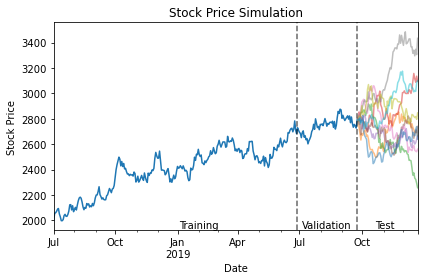

In [24]:
# Generate train and validation set
REMOVE_DATA_THRESHOLD =  0.01

paras = {
    'underlying_paras':{'s0': 2000.,'volatility': 0.2,'mu': 0.1,
                        'start_date': pd.Timestamp('2018/07/01'),
                        'end_date': pd.Timestamp('2018/07/01') + pd.Timedelta('450D')},
    
    'option_paras':{'threshold': 1, 'step_K': 5},
    'offset_dict': {'1D': [BDay(1), '_1D'], '2D': [BDay(2), '_2D']},
    'other_paras': {'short_rate': 0.,'norm_factor': 100.}
}

result_dict = make_clean_data(strike_per_maturity=None, **paras)
df_call, df_put = result_dict['call'], result_dict['put']
df_call['is_test_sample'], df_put['is_test_sample'] = False, False
path = result_dict['path']
strike_per_maturity = result_dict['strike_per_maturity']

total_call, total_put = df_call.shape[0], df_put.shape[0]

df_call = df_call.loc[(df_call['V0'] > REMOVE_DATA_THRESHOLD)]
num_rem_call = total_call - df_call.shape[0]

df_put = df_put.loc[(df_put['V0'] > REMOVE_DATA_THRESHOLD)]
num_rem_put = total_put - df_put.shape[0]

df_both = df_call.append(df_put, ignore_index=True)
os.makedirs(DATA_DIR, exist_ok=True)
df_both.to_csv(DATA_DIR + 'train_validation_data.csv')

DATE_BREAK = pd.Timestamp('2018/07/01') + pd.Timedelta('360D')
# Generate Monte Carlo test sets
underlying_params = copy.deepcopy(paras['underlying_paras'])
number_of_test_days = pd.Timedelta('90D')


plot_stock_test_prices(path, underlying_params, number_of_test_days, DATE_BREAK,
                       paras['underlying_paras']['end_date'])

init_test_value = path.iloc[-1]
test_start_date = paras['underlying_paras']['end_date']
test_end_date = paras['underlying_paras']['end_date'] + number_of_test_days
paras['underlying_paras']['start_date'] = test_start_date
paras['underlying_paras']['end_date'] = test_end_date
paras['underlying_paras']['s0'] = init_test_value['S0']

os.makedirs(DATA_DIR, exist_ok=True)

Then we perform the following actions:

1. We set the `RANDOM_SEED` and initialize an empty list `test_sizes`.
2. We set the random seed using `np.random.seed()` for reproducibility.
3. We iterate `NUM_TEST` times to generate Monte Carlo test sets.
4. Inside the loop, we call the `make_clean_data` function with the `making_tests` flag set to `True` to generate the test data. We assign the resulting call and put dataframes to `df_call` and `df_put`, respectively.
5. We set the `'is_test_sample'` column of both dataframes to `True` to indicate that these samples are part of the test sets.
6. We filter out any data points with an initial option price (`V0`) below the threshold `REMOVE_DATA_THRESHOLD`.
7. We combine the call and put dataframes into a single dataframe `df_both`.
8. We store the size of the test set (`df_both.shape[0]`) in the `test_sizes` list.
9. We save the test set dataframe as a CSV file with a filename based on the loop index.
10. We define the file path for the `paras.txt` file and create a list of parameter names and their corresponding values.
11. We open the file in write mode and write each parameter name and value to a new line in the file.
12. The loop continues for the specified number of tests, generating separate test sets for each iteration.
13. Finally, we have the test sizes stored in the `test_sizes` list and the parameters written to the `paras.txt` file.

In [25]:
RANDOM_SEED = 666
test_sizes = []
np.random.seed(2 * RANDOM_SEED)

result_dict = make_clean_data(making_tests=True, strike_per_maturity=strike_per_maturity, **paras)
df_call, df_put = result_dict['call'], result_dict['put']
df_call['is_test_sample'], df_put['is_test_sample'] = True, True
path = result_dict['path']
df_call = df_call.loc[(df_call['V0'] > REMOVE_DATA_THRESHOLD)]
df_put = df_put.loc[(df_put['V0'] > REMOVE_DATA_THRESHOLD)]
df_both = df_call.append(df_put, ignore_index=True)
test_sizes.append(df_both.shape[0])
df_both.to_csv(DATA_DIR + 'test_data.csv')

# Save parameters to a file
file_path = f'{DATA_DIR}/data_info.txt'

# Define the list of parameter names and their corresponding values
parameters = [
    ('Random seed', RANDOM_SEED),
    ('Normalized price', paras['other_paras']['norm_factor']),
    ('Training start date', paras['underlying_paras']['start_date']),
    ('Number of total samples', total_call + total_put),
    ('The number of call samples removed from training and validation set, due to threshold', num_rem_call),
    ('The number of put samples removed from training and validation set, due to threshold', num_rem_put),
    ('Test start date:', test_start_date),
    ('Test end date:', test_end_date)
]

# Open the file in write mode and write the parameter names and values
with open(file_path, 'w+') as file:
    for parameter_name, parameter_value in parameters:
        # Write each parameter name and value to the file, followed by a newline character
        file.write(f'{parameter_name} = {parameter_value}\n')

Number of options: 1529
